In [ ]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


(75000, 167)
(25000, 167)
(75000,)
(25000,)
[21:12:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[-0.23649043 -0.21425861 -0.22047895 ... -0.25331414 -0.25405455
 -0.25271714]
[-0.2257 -0.2124 -0.2096 ... -0.2432 -0.2387 -0.2647]


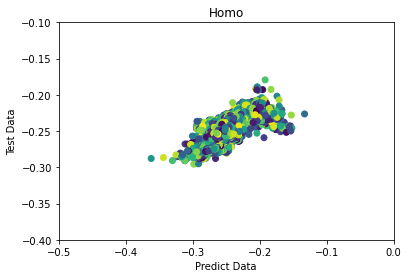

The R^2 score is:  0.26790427406368233
The RMSE score is:  0.00010721707782560042
The MAE score is:  0.007754363271007539


In [ ]:

import xgboost as xgb
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import sqlite3
import numpy as np
import csv
from rdkit import Chem
from rdkit.Chem import MACCSkeys

def Transform_Data():
    
    SMILESdata, HomoData, LumoData = readCSV('data/qm9.csv')
    SMILESstrings = list(SMILESdata.keys())
    FeatureVector = []
    BadParticles = []
    for string in SMILESstrings:
        mol = Chem.MolFromSmiles(SMILESdata[string])
        if(mol != None):
            fp = MACCSkeys.GenMACCSKeys(mol)
            fpBits = fp.ToBitString()
            FeatureVector.append(split(fpBits))
        else:
            BadParticles.append(string)
    X = np.array(FeatureVector[:75000])
    Z = np.array(FeatureVector[75000:100000])
    print(X.shape)
    print(Z.shape)
    for keys in BadParticles:
        del HomoData[keys]
        del LumoData[keys]
    HomoData = list(HomoData.values())
    LumoData = list(LumoData.values())
    y1 = np.array(HomoData[:75000])
    y2 = np.array(LumoData[:75000])
    w1 = np.array(HomoData[75000:100000])
    w2 = np.array(LumoData[75000:100000])
    print(y1.shape)
    print(w1.shape)
    return X, Z, w1, w2, y1, y2

def split(bitString):
    
    return [int(char) for char in bitString] 

def readCSV(filepath):

    Smile_Strings = {}
    Homo_Id = {}
    Lumo_Id = {}
    with open(filepath, newline = '') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            Smile_Strings[row['mol_id']] = row['smiles']
            Homo_Id[row['mol_id']] = float(row['homo'])
            Lumo_Id[row['mol_id']] = float(row['lumo'])
    
    return Smile_Strings, Homo_Id, Lumo_Id
    

    
def Create_Model():
    
    model = xgb.XGBRegressor()
    X, Z, w1, w2, y1, y2= Transform_Data()
    model.fit(X, y1)
    predict = model.predict(Z)
    print(predict)
    print(w1)
    c = np.random.rand(25000)
    pyplot.scatter(w1, predict, c=c)
    pyplot.ylabel('Test Data')
    pyplot.xlabel('Predict Data')
    pyplot.title('Homo')
    pyplot.xlim(-0.5, 0)
    pyplot.ylim(-0.4, -0.1)
    pyplot.show()
    R_squared = r2_score(predict, w1)
    RMSE = mean_squared_error(predict, w1)
    MAE = mean_absolute_error(predict, w1)
    print("The R^2 score is: ",R_squared)
    print("The RMSE score is: ", RMSE)
    print("The MAE score is: ", MAE)
            
if __name__ == "__main__":
    Create_Model()

